# Examples for pAGN

These are some of the examples for the pAGN package

## Getting Started

First, import package

In [16]:
import Thompson
import Sirko
import numpy as np
import matplotlib.pyplot as plt
import constants as ct

Define input parameters for the AGN disk. 

In [17]:
#Sirko & Goodman 2003
Mbh=1e8*ct.MSun #10^8 solar mass SMBH
le=0.5 #Eddington ratio
Mdot= None #let the accretion rate be calculated through lE
alpha=0.01 #standard Shakura Sunyaev parameter value
X=0.7 #Hydrogen abundance is 0.7 for this disk
b=0 #Let's see the alpha-disk case
Opacity="combined" #most up to date opacity values

In [18]:
#Thompson et al. 2005
sigma = 300e3 #stellar dispersion relation
mbh = (2e8*ct.MSun) * ((sigma / 200e3) ** 4) #let's use our own M-sigma relation to find mass
epsilon=1e-3 #Star formation radiative efficiency
m= 0.2 #Value for angular momentum efficiency as suggested by Thompson et al. 2005
xi= 1. #Approximate supernovae radiative fraction as suggested by Thompson et al. 2005
Mdot_out=None #For mbh in 10^8-10^9 Msun range, the outer accretion rate scaling should be sufficient for bright AGN formation
Rout=None #Let's use 1e7 Schwarzchild radii for outer boundary
Rin=None #Rin is 3 Schwarzchild radii 
opacity="combined" #most up to date opacity values

We now solve the disk equations. Note that when calling the SirkoAGN and ThompsonAGN models, there is a printout of the input parameters. This can be used to check that the units have been correctly converted and what the outputs of the scalings are.

In [19]:
sk = Sirko.SirkoAGN(Mbh=Mbh, le=le, Mdot=Mdot, alpha=alpha, X=X, 
                    b=b, opacity = Opacity)
sk.solve_disk(N=1e4) #10^4 tends to be a sufficient resolution for most Mbh values

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 1.298344e+00 MSun/yr
le = 0.5
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3408 (R=7.92e+02 Rs)
Beginning star formation at index 3408
Mdisk = 335459537.4383986 Msun
Mdisk/Mbh = 3.354595374383986


In [31]:
tho = Thompson.ThompsonAGN(Mbh = mbh, sigma = sigma, epsilon = epsilon, m = m, xi = xi,
                      Mdot_out= Mdot_out, Rout = Rout, Rin = Rin, opacity =opacity)
tho.solve_disk(N=1e4)

### Thompson et al. 2005 parameters ###
Mbh = 1.012500e+09 MSun
Mdot_out = 8.311237e+03 MSun/yr
Rs = 9.689748e-05 pc
Rin = 3.000000e+00 Rs
Rout = 1.000000e+07 Rs = 9.689748e+02 pc
sigma = 3.000000e+02 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = custom

debug = False
xtol = 1e-10
root method = lm
 ### Beginning integration at Rmax ###
### Switching to no star formation regime at i = 6852, R = 88496.08074591904Rs ###
Mdisk = 90039952747.54353 Msun
Mdisk/Mbh = 88.92834839263558


To quickly check that the Sirko & Goodman model ran correctly, we can plot some key parameters

In [ ]:
sk.plot()

The Sirko & Goodman model tends to be simpler than the Thompson et al model. We expect the temperature of the disk to decrease with distance from the central BH, starting at values of 10^5-10^6 Kelvin, depending on the mass of the central BH. The h/r ratio should stay below one, at least in the inner regions of the disk. The vertical line shows where we have switched from the inner regime to the outer regime.

We can similarly check the Thompson et al model ran correctly.

In [ ]:
tho.plot()

The Thompson et al. model tends to be more complicated than the Sirko & Goodman model. We expect the temperature of the disk to decrease with distance from the central BH, starting at values of 10^5 Kelvin and dropping to lower temperature values than for the Sirko & Goodman case, depending on the mass of the central BH. The optical depth $\tau$ should look more complex than in the Sirko & Goodman case. The h/r ratio should stay below one, at least in the inner regions of the disk. The vertical line shows where we have switched from the inner regime to the outer regime.

A significant difference between the Thompson et al. model and the Sirko and Goodman model is that the Thompson et al. model has a varying accretion rate $\dot{M}$. To check that enough gas is being accreted onto the central BH, one can also plot the accretion rate in the Thompson et al. disk:

In [ ]:
tho.plot_mdot()

We see that in this case, $\dot{M}_{\rm out}$ is below the critical accretion rate $\dot{M}_{\rm c}$ at the outer boundary. However, the accretion rate at the central BH is $\approx 5 \, M_{\odot}/{\rm yr}$, which is deemed enough to fuel a bright AGN.

One may also wish to save their results in a txt file.

In [ ]:
def save(obj, filename):
    """Method to save key AGN model parameters to filename
    
    Parameters
    ----------
    obj: object
        Python object representing a solved AGN disk either from the Sirko & Goodman model
        or from the Thompson model
    
    """
    pgas = sk.rho * sk.T * ct.Kb / ct.massU
    prad = 4 * ct.sigmaSB * (sk.T ** 4) / (3 * ct.c)
    cs = np.sqrt((pgas + prad) / (sk.rho))
    omega = obj.Omega
    rho = obj.rho
    h = obj.h
    T = obj.T
    tauV = obj.tauV
    Q = obj.Q
    R = obj.R
    if hasattr(obj, "eta"):
        np.savetxt(filename, np.vstack((R/ct.pc, Omega, T, rho, h, obj.eta, cs, tauV, Q)).T)
    else:
        np.savetxt(filename, np.vstack((R/ct.pc, Omega, T, rho, h, cs, tauV, Q)).T)


### Custom Opacity

Both SirkoAGN and ThompsonAGN can take in a custom opacity. The opacity values have to be provided in a specific format for this to work. Below, we generate some fake opacity values and show how to input them into the models.

In [ ]:
#First, generate or provide the temperature and density arrays over which the opacity grid
#is constructed. These must be in SI units. They should also ideally cover values of 
#rho in the range [10^-15 g/m^3, 10^-4 g/m^3] and temperature in the range [10 K, 10^6 K].
rho_arr = np.logspace(-15, -4, 10)
temp_arr = np.logspace(1, np.log10(999999), 1001)
#generate kappa values in units of m^2/kg over this grid
kappa_arr = np.ones((len(rho_arr), len(temp_arr)))*0.6 #simple example where opacity is 0.6 m^2/kg for all rho and T values

print(kappa_arr.shape)
#input the following into either models:
opacity = (kappa_arr, rho_arr, temp_arr)

#the Sirko & Goodman model with this custom opacity
sk_co = Sirko.SirkoAGN(opacity = opacity)
sk_co.solve_disk()

tho_co = Thompson.ThompsonAGN(opacity = opacity)
tho_co.solve_disk()

In [ ]:
#As before, we can check the custom opacity models worked by quickly plotting the key parameters:
sk_co.plot()
tho_co.plot()

In [ ]:
#We can also directly check what the opacity values look like for this disk:
plt.plot(np.log10(sk_co.R), np.log10(sk_co.kappa), label = "Sirko & Goodman")
plt.plot(np.log10(tho_co.R), np.log10(tho_co.kappa), "--", label = "Thompson et al")
plt.xlim((12, 19))
plt.ylim((-0.224, -0.22))
plt.show()

Unsurprisingly, we get a flat line for our $\kappa$ values. 

### Luminosities

To calculate the bolometric luminosity of the AGN disks, we use Eq. 47 from Thompson et al. 2005:

\begin{equation}
L_{\rm disk} = \int_{\lambda_{\rm min}}^{\lambda_{\rm max}} L_{\lambda} \mathrm{d}\lambda = 2 \pi h c^2\int_{\lambda_{\rm min}}^{\lambda_{\rm max}} \frac{1}{\lambda^4} \mathrm{d}\lambda \int_{r_{\rm min}}^{r_{\rm out}} \frac{2 \pi r \, \mathrm{d}r}{\exp{ \{ \frac{h c}{\lambda T_{\rm eff}  }\} -1}}
\end{equation}

We approximate these integrals as sums:

In [ ]:
def calculate_lum_sum(Teffarr, wavelengthmin, wavelengthmax, rarr, deltar):
    """Calculates luminosity of AGN disk using sums
    
    Parameters
    ----------
    Teffarr: array
        Array of effective temperature values calculated for each value in rarr in K
    wavelengthmin: float
        Minimum wavelength value in m
    wavelengthmax: float
        Maximum wavelength value in m
    rarr: array
        Array of distance from central BH values in m
    
    Results
    -------
    I: float
        Integrated value of luminosities over given wavelength range in Watts
    """
    lambarredge = np.logspace(np.log10(wavelengthmin), np.log10(wavelengthmax), 1000)
    deltalambda = lambarredge[1:] - lambarredge[:1]
    lambarr = (lambarredge[:-1] + lambarredge[1:])/2
    
    r_int_arr = np.zeros(len(lambarr))
    for il, lamb in enumerate(lambarr):
        #the exponential factor in the integral. If it is too large, there is an overflow error, but these values give an integral value of zero so we can safely ignore their values.
        exp_factor = ct.h * ct.c / (lamb * ct.Kb * Teffarr)
        I_sum = sum(2*np.pi*rarr[exp_factor < 40]*deltar[exp_factor < 40]/(np.exp(exp_factor[exp_factor < 40])) - 1)
        #calculate integral in r
        r_int_arr[il] += I_sum
    #calculate full integral
    I = sum(2*np.pi*ct.h*ct.c*ct.c*deltalambda*r_int_arr/(lambarr*lambarr*lambarr*lambarr))
    return I

In [ ]:
calculate_lum_sum(tho.Teff4**0.25, 1e-8, 1e-3, tho.R, tho.deltaR)

### Migration Torques

Below, we provide the code for a more in depth use case of pAGN, looking at the migration torques a 50 M$_\odot$ BH in an AGN would experience while orbiting a central BH.

In [53]:
from scipy.interpolate import UnivariateSpline
from opacities import electron_scattering_opacity
import matplotlib.lines as mlines

In [50]:
def gamma_0(q, hr, Sigma, r, Omega):
    """
    Method to find the normalization torque
    
    Parameters
    ----------
    q: float/array
        Float or array representing the mass ratio between the migrator and the central BH.
    hr: float/array
        Float or array representing the disk height to distance from central BH ratio.
    Sigma: float/array
        Float or array representing the disk surface density in kg/m^2
    r: float/array
        Float or array representing the distance from the central BH in m
    Omega: float/array
        Float or array representing the angular velocity at the migrator position in SI units.
    
    Returns
    -------
    gamma_0: float/array
        Float or array representing the single-arm migration torque on the migrator in kg m^2/ s^2.
    
    """
    gamma_0 = q*q*Sigma*r*r*r*r*Omega*Omega/(hr*hr)
    return gamma_0


def gamma_iso(dSigmadR, dTdR):
    """
    Method to find the locally isothermal torque.
    
    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
        
    Returns
    -------
    gamma_iso: float/array
        Float or array representing the locally isothermal torque on the migrator in kg m^2/ s^2.
    
    """
    alpha = - dSigmadR
    beta = - dTdR
    gamma_iso = - 0.85 - alpha - 0.9*beta
    return gamma_iso


def gamma_ad(dSigmadR, dTdR):
    """
    Method to find the adiabatic torque.
    
    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
        
    Returns
    -------
    gamma_ad: float/array
        Float or array representing the adabiatic torque on the migrator in kg m^2/ s^2.
    
    """
    alpha = - dSigmadR
    beta = - dTdR
    gamma = 5/3
    xi = beta - (gamma - 1)*alpha
    gamma_ad = - 0.85 - alpha - 1.7*beta + 7.9*xi/gamma
    return gamma_ad


def dSigmadR(obj):
    """
    Method that interpolates the surface density gradient of an AGN disk object.
    
    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dSigmadR: float/array
        Discrete array of the log surface density gradient.
    
    """
    Sigma = 2*obj.rho*obj.h # descrete
    rlog10 = np.log10(obj.R)  # descrete
    Sigmalog10 = np.log10(Sigma)  # descrete
    Sigmalog10_spline = UnivariateSpline(rlog10, Sigmalog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dSigmadR_spline =  Sigmalog10_spline.derivative()
    dSigmadR = dSigmadR_spline(rlog10)
    return dSigmadR


def dTdR(obj):
    """
    Method that interpolates the thermal gradient of an AGN disk object.
    
    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dTdR: float/array
        Discrete array of the log thermal gradient.
    
    """
    rlog10 = np.log10(obj.R)  # descrete
    Tlog10 = np.log10(obj.T)  # descrete
    Tlog10_spline = UnivariateSpline(rlog10, Tlog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dTdR_spline = Tlog10_spline.derivative()
    dTdR = dTdR_spline(rlog10)
    return dTdR


def dPdR(obj):
    """
    Method that interpolates the total pressure gradient of an AGN disk object.
    
    Parameters
    ----------
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.

    Returns
    -------
    dPdR: float/array
        Discrete array of the log total pressure gradient.
    
    """
    rlog10 = np.log10(obj.R)  # descrete
    pgas = obj.rho * obj.T * ct.Kb / ct.massU
    prad = obj.tauV*ct.sigmaSB*obj.Teff4/(2*ct.c)
    ptot = pgas + prad
    Plog10 = np.log10(ptot)  # descrete
    Plog10_spline = UnivariateSpline(rlog10, Plog10, k=3, s=0.005, ext=0)  # need scipy ver 1.10.0
    dPdR_spline = Plog10_spline.derivative()
    dPdR = dPdR_spline(rlog10)
    return dPdR


def CI_p10(dSigmadR, dTdR):
    """
    Method to calculate torque coefficient for the Paardekooper et al. 2010 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    cI: float/array
        Paardekooper et al. 2010 migration torque coefficient
    """
    cI = -0.85 + 0.9*dTdR + dSigmadR
    return cI


def CI_jm17_tot(dSigmadR, dTdR, gamma, obj):
    """
    Method to calculate torque coefficient for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.
    

    Returns
    -------
    cI: float/array
        Jiménez and Masset 2017 migration torque coefficient
    """
    cL = CL(dSigmadR, dTdR, gamma, obj)
    cI = cL + (0.46 + 0.96*dSigmadR - 1.8*dTdR)/gamma
    return cI


def CI_jm17_iso(dSigmadR, dTdR):
    """
    Method to calculate the locally isothermal torque coefficient for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.

    Returns
    -------
    cI: float/array
        Jiménez and Masset 2017 migration locally isothermal torque coefficient
    """
    cI = -1.36 + 0.54*dSigmadR + 0.5*dTdR
    return cI


def CL(dSigmadR, dTdR, gamma, obj):
    """
    Method to calculate the Lindlblad torque for the Jiménez and Masset 2017 values.

    Parameters
    ----------
    dSigmadR: float/array
        Discrete array representing the log surface density gradient in the disk.
    dTdR: float/array
        Discrete array representing the log thermal gradient in the disk.
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.
    

    Returns
    -------
    cL: float/array
        Jiménez and Masset 2017 Lindblad torque coefficient
    """
    xi = 16*gamma*(gamma - 1)*ct.sigmaSB*(obj.T*obj.T*obj.T*obj.T)\
         /(3*obj.kappa*obj.rho*obj.rho*obj.h*obj.h*obj.Omega*obj.Omega)
    x2_sqrt = np.sqrt(xi/(2*obj.h*obj.h*obj.Omega))
    fgamma = (x2_sqrt + 1/gamma)/(x2_sqrt+1)
    cL = (-2.34 - 0.1*dSigmadR + 1.5*dTdR)*fgamma
    return cL


def gamma_thermal(gamma, obj, q):
    """
    Method to calculate the thermal torque from the Masset 2017 equations.

    Parameters
    ----------
    gamma: float
        Adiabatic index
    obj: object
        Either a SirkoAGN or ThompsonAGN object representing the AGN disk being considered.
    q: float/array
        Float or array representing the mass ratio between the migrator and the central BH.

    Returns
    -------
    g_thermal: float/array
        Masset 2017 migration total thermal torque.
    """
    xi = 16 * gamma * (gamma - 1) * ct.sigmaSB * (obj.T * obj.T * obj.T * obj.T) \
         / (3 * obj.kappa * obj.rho * obj.rho * obj.h * obj.h * obj.Omega * obj.Omega)
    mbh = obj.Mbh*q
    Lc = 4*np.pi*ct.G*mbh*obj.rho*xi/gamma
    lam = np.sqrt(2*xi/(3*gamma*obj.Omega))

    dP = -dPdR(obj)
    xc = dP*obj.h*obj.h/(3*gamma*obj.R)

    # eta = -dSigmadR(obj)/3 + (-dTdR(obj) + 3)/6
    # xc = eta*obj.h*obj.h/obj.R
    kes = electron_scattering_opacity(X=0.7)
    L = 4 * np.pi * ct.G * ct.c * mbh / kes
    g_thermal = 1.61*(gamma - 1)*xc*(L/Lc - 1)/(gamma*lam)
    return g_thermal

### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+06 MSun
Mdot = 1.298344e-02 MSun/yr
le = 0.5
Rs = 9.570121e-08 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e-01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=5849 (R=2.62e+04 Rs)
Beginning star formation at index 5849
Mdisk = 703749.3876329744 Msun
Mdisk/Mbh = 0.7037493876329745
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 0.000000e+00 MSun/yr
Rs = 9.570121e-08 pc
Rin = 3.000000e+00 Rs
Rout = 2.089838e+09 Rs = 2.000000e+02 pc
sigma = 6.345392e+01 km/s
epsilon =  0.001
m =  0.2
xi =  1.0
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
sigma from M using M-sigma relation
### Thompson et al. 2005 parameters ###
Mbh = 1.000000e+06 MSun
Mdot_out = 1.500000e-02 MSun/yr
Rs = 9.570121e-08 pc
Rin = 3.000000e+00 Rs
Rout = 1.000000e+07 Rs = 9.570121e-01 pc
sigma = 6.345392e+01 km/s

/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


### Switching to no star formation regime at i = 8859, R = 1803290.9434440897Rs ###
Mdisk = 71499.93976318742 Msun
Mdisk/Mbh = 0.07149993976318743


/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/numpy/ma/core.py:6957: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/ddg672/Desktop/PycharmProjects/selection_effects/pdet_venv/lib/python3.8/site-packages/nu

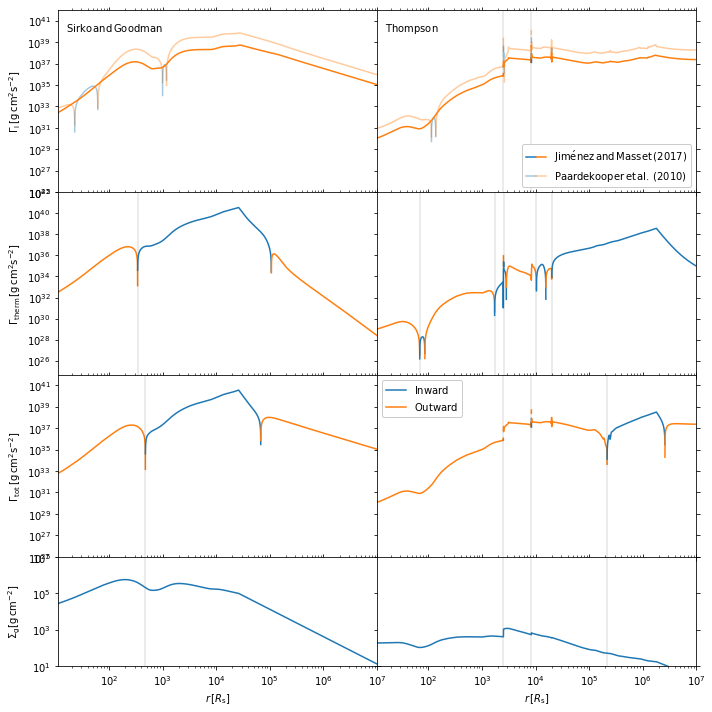

In [55]:
disk_name = ['sirko', 'thompson']
d_counter = 0

f, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey='row', gridspec_kw=dict(hspace=0, wspace =0, height_ratios = (2, 2, 2, 1.2)), tight_layout=True)
for axx in axes.flatten():
    axx.set_yscale('log')
    axx.set_xscale('log')

for dname in disk_name:
    Mbh = 1e6
    q = 5e-6
    if dname == 'thompson':

        objin = Thompson.ThompsonAGN(Mbh = Mbh*ct.MSun, Mdot_out=0.,) #Sirko.SirkoAGN(Mbh = Mbh, b=0)  #
        rout = objin.Rs*(1e7)
        sigma = 200 * (Mbh / 1.3e8) ** (1 / 4.24)
        Mdot_out = 1.5e-2
        obj = Thompson.ThompsonAGN(Mbh=Mbh*ct.MSun, Rout = rout, Mdot_out=Mdot_out*ct.MSun/ct.yr)  # Sirko.SirkoAGN(Mbh = Mbh, b=0)  #
        obj.solve_disk(N=1e4)
    else:
        le = 0.5
        alpha = 0.01
        obj = Sirko.SirkoAGN(Mbh=Mbh*ct.MSun, le=le, alpha=alpha, b=0)
        obj.solve_disk(N=1e4)

    #Bellovary equations
    Gamma_0 = gamma_0(q, obj.h / obj.R, 2 * obj.rho * obj.h, obj.R, obj.Omega)

    #Grishin equations
    dSig = dSigmadR(obj)
    dT = dTdR(obj)
    cI_p10 = CI_p10(dSig, dT)
    Gamma_I_p10 = cI_p10*Gamma_0
    gamma = 5/3

    cI_jm_tot = CI_jm17_tot(dSig, dT, gamma, obj)
    Gamma_I_jm_tot = cI_jm_tot*Gamma_0
    Gamma_therm = gamma_thermal(gamma, obj, q)*Gamma_0*obj.R/obj.h

    Gamma_tot = Gamma_therm + Gamma_I_jm_tot

    #-----Plotting-----#


    linestyles = ['-', '--', '-.', ':']
    ax = axes[:, d_counter]
    if hasattr(obj, 'alpha'):
        ax[0].text(10 ** 1.2, 10 ** 40,  r'${\rm Sirko \, and \, Goodman}$' )
    else:
        ax[0].text(10 ** 1.2, 10 ** 40,  r'${\rm Thompson}$')

    for iGamma, Gamma in enumerate([Gamma_I_jm_tot, Gamma_therm, Gamma_tot]):
        maskg = Gamma >= 0
        indices = np.nonzero(maskg[1:] != maskg[:-1])[0] + 1
        Gammas = np.split(Gamma, indices)
        Rs = np.split(obj.R, indices)
        ignnum = 0
        ignum2 = 0
        for iseg, seg in enumerate(Gammas):
            if seg[0] > 0.:
                if Rs[iseg][0] / obj.Rs > ignnum + 50:
                    ax[iGamma].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color = 'k', alpha = 0.1)
                    ignnum = Rs[iseg][0] / obj.Rs

                ax[iGamma].plot(Rs[iseg]/obj.Rs, abs(seg)*ct.SI_to_gcm2, c='C0', zorder = 2)
                if iGamma == 2 and Rs[iseg][0] / obj.Rs > ignum2 + 50:
                    ax[3].axvline(Rs[iseg][0] / obj.Rs, -100, 100, color='k', alpha=0.1)
                    ignum2 = Rs[iseg][0] / obj.Rs

            else:
                ax[iGamma].plot(Rs[iseg] / obj.Rs, abs(seg*ct.SI_to_gcm2) , c='C1', zorder = 2)
        if iGamma == 0:
            Gamma2 = Gamma_I_p10
            maskg2 = Gamma2 >= 0
            indices2 = np.nonzero(maskg2[1:] != maskg2[:-1])[0] + 1
            Gammas2 = np.split(Gamma2, indices2)
            Rs2 = np.split(obj.R, indices2)
            for iseg2, seg2 in enumerate(Gammas2):

                if seg2[0] > 0.:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C0', zorder = 1, alpha = 0.4)
                else:
                    ax[iGamma].plot(Rs2[iseg2] / obj.Rs, abs(seg2), c='C1', zorder = 1, alpha = 0.4)
    ax[3].plot(obj.R/obj.Rs, 2*obj.h*obj.rho*ct.SI_to_gcm2, label = r"$\Sigma_{\rm g} [{\rm g cm}^{-2}]$")


    d_counter += 1
    
pos_line = mlines.Line2D([], [], color='C0', marker='s',
                           markersize=0, label=r'$\rm{Inward}$')
neg_line = mlines.Line2D([], [], color='C1', marker='s',
                            markersize=0, label=r'$\rm{Outward}$')
artists_handles = [pos_line, neg_line]
axes[2, 1].legend(handles=artists_handles, framealpha = 1)

pos_line2 = mlines.Line2D([], [], color='C0', marker='s', alpha = 0.4,
                         markersize=0,)
neg_line2 = mlines.Line2D([], [], color='C1', marker='s', alpha = 0.4,
                         markersize=0,)
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
axes[0,1].legend(handles=[(pos_line, neg_line), (pos_line2, neg_line2,) ],
                 labels=[r'${\rm Jim \acute{e} nez \, and \, Masset \, (2017)}$', r'$\rm Paardekooper \, et \, al. \, (2010)$',],
                 handler_map = {tuple: HandlerTuple(ndivide = None, pad = 0.)},
                 framealpha = 1)

axes[0,0].set_ylabel(r'${\Gamma_{\rm I} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[1,0].set_ylabel(r'${\Gamma_{\rm therm} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[2,0].set_ylabel(r'${\Gamma_{\rm tot} \, {\rm [g \, cm}^{2}{\rm s}^{-2}{\rm ]} }$')
axes[3, 0].set_ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')

x_label = r"$r \, [R_{\rm s}]$"
axes[3, 0].set_xlabel(x_label)
axes[3, 1].set_xlabel(x_label)

axes[0, 0].set_ylim((1e25, 1e42))


axes[1, 0].set_ylim((5e24, 1e42))

axes[2, 0].set_ylim((1e25, 1e42))


axes[3, 0].set_ylim((1e1, 1e7))

for axx in axes.flatten():
    axx.yaxis.set_ticks_position('both')
    axx.xaxis.set_ticks_position('both')
    axx.set_xlim((1e1, 1e7))
axes[0,1].set_xlim((1.1e1, 1e7))

f.align_ylabels()
plt.show()